In [36]:
import pandas as pd
import numpy as np

filepath = '/home/justus/ml-exploration/pytorch-explore/AAPL model v1/AAPL.csv'

df = pd.read_csv(filepath)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')


df.head()

,Date,Close,Volume,Open,High,Low
2514,2012-08-17,23.1468,441829183,22.8572,23.1497,22.8147
2513,2012-08-20,23.7554,611969715,23.2147,23.7554,23.2107
2512,2012-08-21,23.4308,811169756,23.9579,24.1029,23.2261
2511,2012-08-22,23.8882,563600295,23.3722,23.8929,23.1468
2510,2012-08-23,23.6654,419420792,23.7897,23.9250,23.6125


<AxesSubplot:xlabel='Date'>

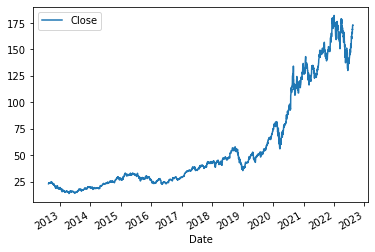

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df.plot(kind='line', x='Date', y='Close')


In [38]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price= df[['Close']]
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

price.head()

/tmp/ipykernel_17175/852040389.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


,Close
2514,-0.890525
2513,-0.883283
2512,-0.887146
2511,-0.881702
2510,-0.884354


In [39]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]



In [40]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim


x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


In [42]:
input_dim = 1
hidden_dim = 32
num_layers = 3
output_dim = 1
num_epochs = 2000

In [43]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device="cuda").requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [44]:
torch.cuda.set_device(0)

x_train = x_train.cuda()
x_test = x_test.cuda()
y_train_gru = y_train_gru.cuda()
y_test_gru = y_test_gru.cuda()


In [45]:
def build_model(params):
    model = GRU(input_dim=input_dim, hidden_dim=params['n_node'], output_dim=output_dim, num_layers=params['n_layer'])
    return(
        model
    )

In [46]:
import time


def train_and_evaluate(param, model):

    model = GRU(input_dim=input_dim, hidden_dim=param['n_node'], output_dim=output_dim, num_layers=param['n_layer'])
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    model = model.cuda()

    hist = np.zeros(num_epochs)
    start_time = time.time()
    gru = []

    for t in range(num_epochs):
        y_train_pred = model(x_train)

        loss = criterion(y_train_pred, y_train_gru)
        hist[t] = loss.item()
        MSE = loss.item()

        optimizer.zero_grad
        loss.backward()
        optimizer.step()

    return MSE


In [47]:
def objective(trial):

    params = {
        'n_node': trial.suggest_int("n_node", 20, 50),
        'n_layer': trial.suggest_int("n_layer", 1, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
    }

    model=build_model(params)

    MSE= train_and_evaluate(params, model)

    return MSE

In [49]:
import optuna

num_epochs = 30

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)



[I 2022-08-21 17:35:27,778] A new study created in memory with name: no-name-e53fe339-b554-4fd3-a9f1-85a621182350
[I 2022-08-21 17:35:28,503] Trial 0 finished with value: 0.05921158567070961 and parameters: {'n_node': 28, 'n_layer': 2, 'learning_rate': 0.0006039770857829567, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.05921158567070961.
[I 2022-08-21 17:35:29,674] Trial 1 finished with value: 0.14718817174434662 and parameters: {'n_node': 50, 'n_layer': 2, 'learning_rate': 0.005203412591131421, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.05921158567070961.
[I 2022-08-21 17:35:30,117] Trial 2 finished with value: 0.08773688971996307 and parameters: {'n_node': 21, 'n_layer': 1, 'learning_rate': 0.00017531692585143373, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.05921158567070961.
[I 2022-08-21 17:35:31,599] Trial 3 finished with value: 0.39496585726737976 and parameters: {'n_node': 45, 'n_layer': 2, 'learning_rate': 0.0001245154442531247, 'optimizer': 'Adam'}. Be

In [50]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

n_node: 41
n_layer: 1
learning_rate: 0.0025248336991285833
optimizer: RMSprop


Add pruning

In [51]:
def build_model(trial):
    model = GRU(input_dim=input_dim, hidden_dim=trial.suggest_int('n_node', 20, 50), output_dim=output_dim, num_layers=trial.suggest_int('n_layer', 1, 5))

    return model

def train_and_evaluate(param, model, trial):
    
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    model = model.cuda()
    criterion = criterion.cuda()

    hist = np.zeros(num_epochs)
    start_time = time.time()
    gru = []
    
    for t in range(num_epochs):
        y_train_pred = model(x_train)

        loss = criterion(y_train_pred, y_train_gru)
        hist[t] = loss.item()
        MSE = loss.item()

        optimizer.zero_grad
        loss.backward()
        optimizer.step()

        trial.report(MSE, t)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return MSE

In [53]:
def objective(trial):

    params = {
        'n_node': trial.suggest_int("n_node", 20, 50),
        'n_layer': trial.suggest_int("n_layer", 1, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
    }

    model = build_model(trial)

    MSE = train_and_evaluate(params, model, trial)

    return MSE

num_epochs = 100
    
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)

[I 2022-08-21 17:50:58,571] A new study created in memory with name: no-name-68871cce-a82f-4c63-8a8b-384142526e6c
[I 2022-08-21 17:51:01,616] Trial 0 finished with value: 0.0018853861838579178 and parameters: {'n_node': 26, 'n_layer': 3, 'learning_rate': 0.0020127001146762608, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.0018853861838579178.
[I 2022-08-21 17:51:09,035] Trial 1 finished with value: 178.96949768066406 and parameters: {'n_node': 38, 'n_layer': 4, 'learning_rate': 0.04073590379586779, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.0018853861838579178.
[I 2022-08-21 17:51:12,239] Trial 2 finished with value: 2.8905506134033203 and parameters: {'n_node': 26, 'n_layer': 3, 'learning_rate': 0.012903931280732658, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.0018853861838579178.
[I 2022-08-21 17:51:16,023] Trial 3 finished with value: 0.8523167371749878 and parameters: {'n_node': 28, 'n_layer': 4, 'learning_rate': 0.08721322819451327, 'optimizer': 'RMSprop'